In [1]:
from rllib.shapeworld import Shape, State, Action, ShapeWorld, GoalWorld
from itertools import combinations, product
import numpy as np
import pandas as pd
import random
from random import sample
from random import Random
from math import log
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from typing import Sequence, Hashable, TypeVar, Generic, Tuple
import pickle
from rllib.mdp import MarkovDecisionProcess
from tqdm import tqdm
from dataclasses import dataclass
from pydantic.dataclasses import dataclass
from typing import Literal
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Formulate the MDP

In [2]:
# First, let's create test shapes and a goal state
test_shape1 = Shape(sides='circle', shade='low', texture='plain')
test_shape2 = Shape(sides='square', shade='medium', texture='stripes')
test_shape3 = Shape(sides='triangle', shade='high', texture='dots')

goal_state = State(shape1=test_shape1, shape2=test_shape2, shape3=test_shape3)

# Initialize ShapeWorld
shape_world = ShapeWorld(goal=goal_state, discount_rate=0.95)

# Test 1: Basic initialization
print("=== Test 1: Basic Initialization ===")
print(f"Discount rate: {shape_world.discount_rate}")
print(f"Goal state: {shape_world.GOAL}")
print(f"Number of possible states: {len(shape_world.state_space)}")
print(f"Number of possible actions: {len(shape_world.action_space)}")




=== Test 1: Basic Initialization ===
Discount rate: 0.95
Goal state: State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='square', shade='medium', texture='stripes'), shape3=Shape(sides='triangle', shade='high', texture='dots'))
Number of possible states: 19683
Number of possible actions: 18


In [3]:
# Test 2: Action Space Verification
print("\n=== Test 2: Action Space Verification ===")
# Verify we have actions for each combination of features and shape pairs
features = ['sides', 'shade', 'texture']
expected_actions = len(features) * 6  # 6 possible actor-recipient pairs for 3 shapes
print(f"Expected number of actions: {expected_actions}")
print(f"Actual number of actions: {len(shape_world.action_space)}")
print("Sample actions:")
for action in shape_world.action_space[:3]:
    print(f"  {action}")




=== Test 2: Action Space Verification ===
Expected number of actions: 18
Actual number of actions: 18
Sample actions:
  Action(feature='sides', actor=1, recipient=2)
  Action(feature='sides', actor=1, recipient=3)
  Action(feature='sides', actor=2, recipient=1)


In [4]:
# Test 3: State Transitions
print("\n=== Test 3: State Transitions ===")
initial_state = State(
    shape1=Shape(sides='circle', shade='low', texture='plain'),
    shape2=Shape(sides='square', shade='medium', texture='stripes'),
    shape3=Shape(sides='triangle', shade='high', texture='dots')
)
test_action = Action(feature='sides', actor=1, recipient=2)

# Get possible next states
possible_states = shape_world.get_possible_next_states(initial_state, test_action)
print(f"Number of possible next states for action {test_action}: {len(possible_states)}")

# Sample a next state
next_state = shape_world.next_state_sample(initial_state, test_action)
print(f"Sample next state after action {test_action}:")
print(f"  Initial shape2: {initial_state.shape2}")
print(f"  Next shape2: {next_state.shape2}")




=== Test 3: State Transitions ===
Number of possible next states for action Action(feature='sides', actor=1, recipient=2): 3
Sample next state after action Action(feature='sides', actor=1, recipient=2):
  Initial shape2: Shape(sides='square', shade='medium', texture='stripes')
  Next shape2: Shape(sides='triangle', shade='medium', texture='stripes')



=== Test 4: Transition Probabilities ===
Transition probability to state with shape2=Shape(sides='triangle', shade='medium', texture='stripes'): 0.10
Transition probability to state with shape2=Shape(sides='circle', shade='medium', texture='stripes'): 0.80

=== Test 5: Reward Function ===
Reward for non-goal transition: -1
Reward for reaching goal: 0

=== Test 6: Visualization ===
Plotting state transitions (this may take a moment)...


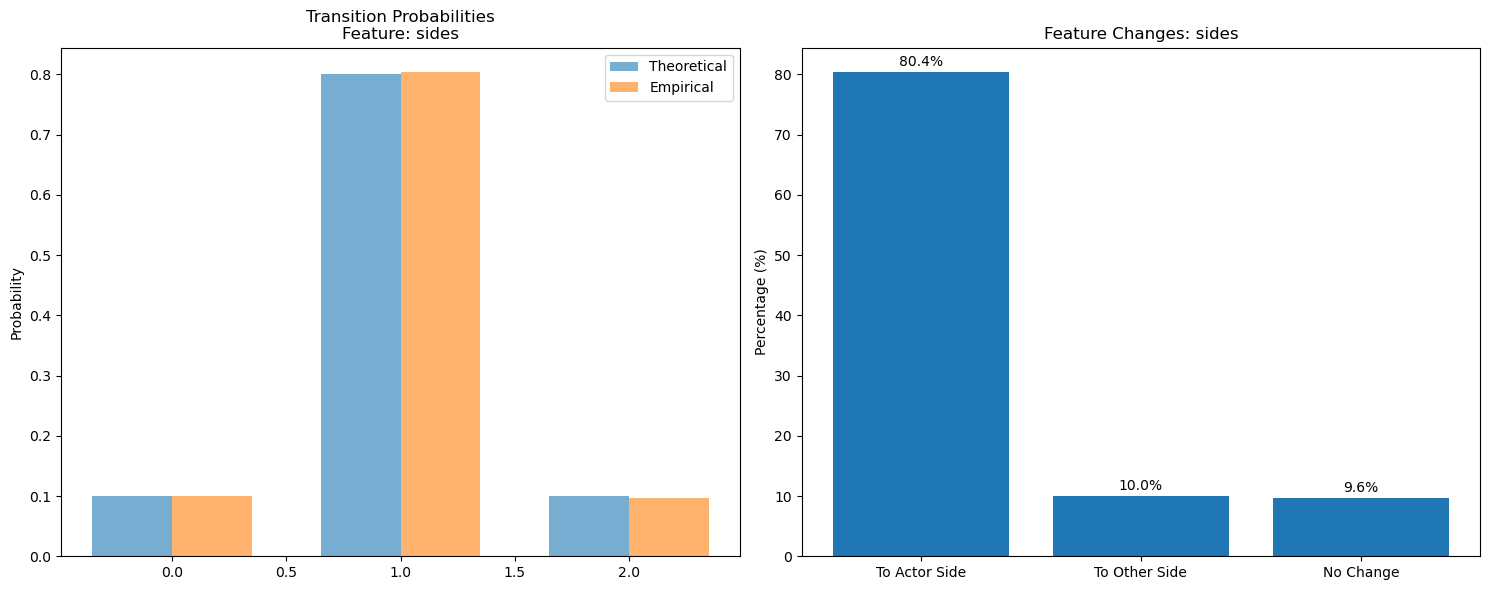


Summary of sides transitions:
Number of possible next states: 3
Number of observed next states: 3

Feature change frequencies:
To Actor Side: 80.4%
To Other Side: 10.0%
No Change: 9.6%


In [5]:
# Test 4: Transition Probabilities
print("\n=== Test 4: Transition Probabilities ===")
for ns in possible_states[:2]:  # Show first two possible next states
    prob = shape_world.transition_probability(initial_state, test_action, ns)
    print(f"Transition probability to state with shape2={ns.shape2}: {prob:.2f}")

# Test 5: Reward Function
print("\n=== Test 5: Reward Function ===")
# Test reward for non-goal transition
reward = shape_world.reward(initial_state, test_action, next_state)
print(f"Reward for non-goal transition: {reward}")

# Test reward for reaching goal
reward = shape_world.reward(initial_state, test_action, goal_state)
print(f"Reward for reaching goal: {reward}")

# Test 6: Visualization
print("\n=== Test 6: Visualization ===")
print("Plotting state transitions (this may take a moment)...")
# Reduce number of samples for testing
shape_world.plot_state_transitions(initial_state, test_action, n_samples=1000)

In [78]:
# Test shade transitions
print("=== Test Shade Transitions ===")

# Case 1: Same shade (low/high to medium)
initial_state = State(
    shape1=Shape(sides='circle', shade='low', texture='plain'),
    shape2=Shape(sides='circle', shade='low', texture='plain'),
    shape3=Shape(sides='circle', shade='medium', texture='plain')
)
shade_action = Action(feature='shade', actor=1, recipient=2)

print("\nCase 1a: Low to Medium (same shade)")
possible_states = shape_world.get_possible_next_states(initial_state, shade_action)
print(possible_states)
print(f"Number of possible next states: {len(possible_states)}")
print("Possible next states for shape2:")
for ns in possible_states:
    prob = shape_world.transition_probability(initial_state, shade_action, ns)
    print(f"  Shade: {ns.shape2.shade}, Probability: {prob:.2f}")



=== Test Shade Transitions ===

Case 1a: Low to Medium (same shade)
[State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='circle', shade='medium', texture='plain'), shape3=Shape(sides='circle', shade='medium', texture='plain')), State(shape1=Shape(sides='circle', shade='low', texture='plain'), shape2=Shape(sides='circle', shade='low', texture='plain'), shape3=Shape(sides='circle', shade='medium', texture='plain'))]
Number of possible next states: 2
Possible next states for shape2:
  Shade: medium, Probability: 0.80
  Shade: low, Probability: 0.20


In [125]:
shape_world.next_state_sample(initial_state, shade_action).shape2

Shape(sides='circle', shade='medium', texture='plain')

In [59]:
# Case 2: Same shade (medium staying or changing)
initial_state = State(
    shape1=Shape(sides='circle', shade='medium', texture='plain'),
    shape2=Shape(sides='circle', shade='medium', texture='plain'),
    shape3=Shape(sides='circle', shade='low', texture='plain')
)
print("\nCase 2: Medium to Medium/Low/High (same shade)")

shade_action = Action(feature='shade', actor=1, recipient=2)
possible_states = shape_world.get_possible_next_states(initial_state, shade_action)
print(f"Number of possible next states: {len(possible_states)}")
print("Possible next states for shape2:")
for ns in possible_states:
    prob = shape_world.transition_probability(initial_state, shade_action, ns)
    print(f"  Shade: {ns.shape2.shade}, Probability: {prob:.2f}")




Case 2: Medium to Medium/Low/High (same shade)
Number of possible next states: 3
Possible next states for shape2:
  Shade: medium, Probability: 0.80
  Shade: low, Probability: 0.10
  Shade: high, Probability: 0.10


In [70]:
shape_world.next_state_sample(initial_state, shade_action).shape2

Shape(sides='circle', shade='medium', texture='plain')

In [127]:
# Case 3: Different shades (moving towards actor)
initial_state = State(
    shape1=Shape(sides='circle', shade='high', texture='plain'),
    shape2=Shape(sides='circle', shade='low', texture='plain'),
    shape3=Shape(sides='circle', shade='medium', texture='plain')
)
print("\nCase 3: Different shades (moving towards actor)")
possible_states = shape_world.get_possible_next_states(initial_state, shade_action)
print(f"Number of possible next states: {len(possible_states)}")
print("Possible next states for shape2:")
for ns in possible_states:
    prob = shape_world.transition_probability(initial_state, shade_action, ns)
    print(f"  Shade: {ns.shape2.shade}, Probability: {prob:.2f}")



Case 3: Different shades (moving towards actor)
Number of possible next states: 1
Possible next states for shape2:
  Shade: medium, Probability: 1.00


In [139]:
shape_world.next_state_sample(initial_state, shade_action).shape2

Shape(sides='circle', shade='medium', texture='plain')


=== Test Texture Transitions ===

Texture transition from plain
Number of possible next states: 1
Possible next states for shape2:
  Texture: stripes, Probability: 1.00

Texture transition from stripes
Number of possible next states: 1
Possible next states for shape2:
  Texture: dots, Probability: 1.00

Texture transition from dots
Number of possible next states: 1
Possible next states for shape2:
  Texture: plain, Probability: 1.00

=== Visualizing Transitions ===

Visualizing shade transition (low to medium)...


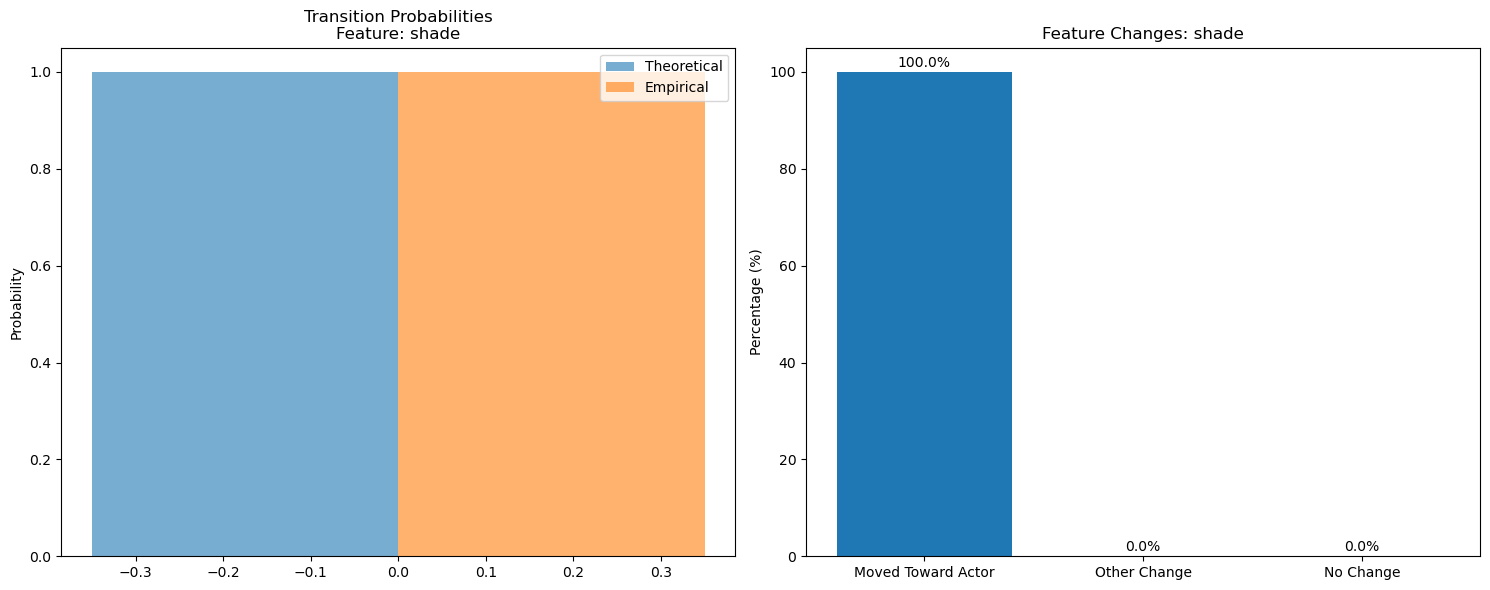


Summary of shade transitions:
Number of possible next states: 1
Number of observed next states: 1

Feature change frequencies:
Moved Toward Actor: 100.0%
Other Change: 0.0%
No Change: 0.0%

Visualizing texture transition (plain to stripes)...


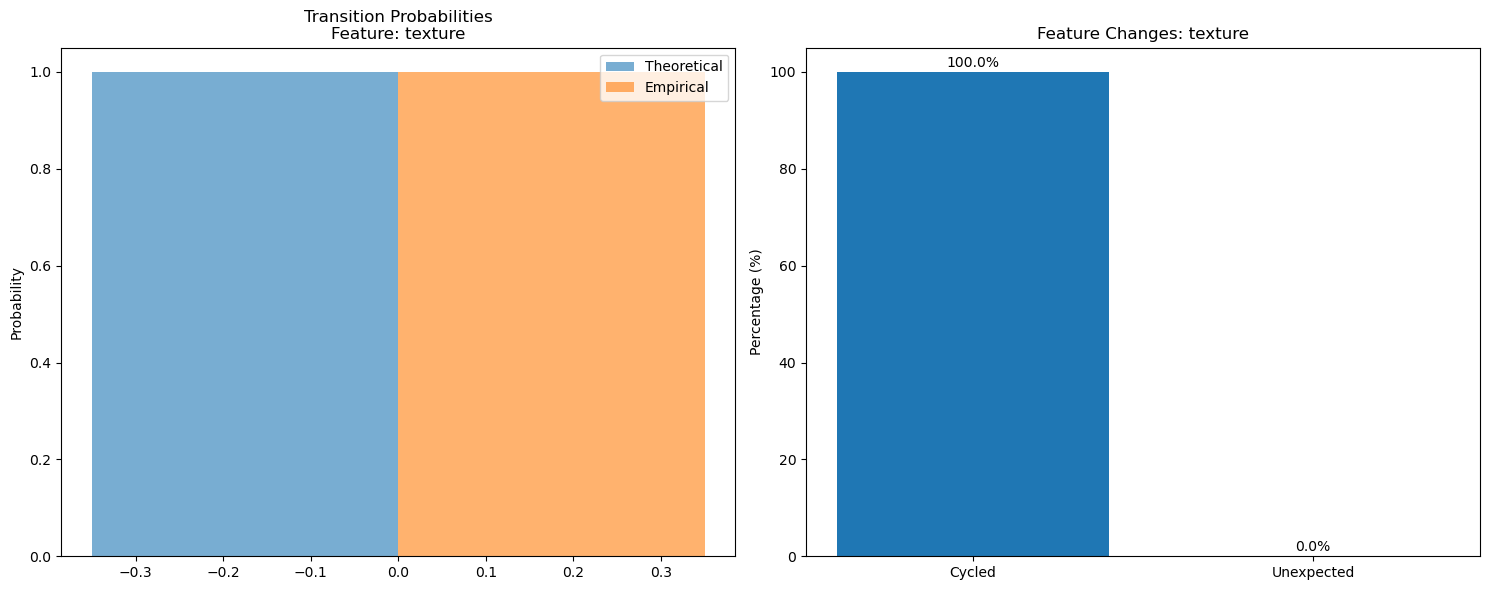


Summary of texture transitions:
Number of possible next states: 1
Number of observed next states: 1

Feature change frequencies:
Cycled: 100.0%
Unexpected: 0.0%


In [140]:

# Test texture transitions
print("\n=== Test Texture Transitions ===")

# Test all possible texture cycles
textures = ['plain', 'stripes', 'dots']
for start_texture in textures:
    initial_state = State(
        shape1=Shape(sides='circle', shade='low', texture='plain'),
        shape2=Shape(sides='circle', shade='low', texture=start_texture),
        shape3=Shape(sides='circle', shade='low', texture='plain')
    )
    texture_action = Action(feature='texture', actor=1, recipient=2)
    
    print(f"\nTexture transition from {start_texture}")
    possible_states = shape_world.get_possible_next_states(initial_state, texture_action)
    print(f"Number of possible next states: {len(possible_states)}")
    print("Possible next states for shape2:")
    for ns in possible_states:
        prob = shape_world.transition_probability(initial_state, texture_action, ns)
        print(f"  Texture: {ns.shape2.texture}, Probability: {prob:.2f}")

# Visualize transitions
print("\n=== Visualizing Transitions ===")

# Shade transition visualization
initial_state = State(
    shape1=Shape(sides='circle', shade='high', texture='plain'),
    shape2=Shape(sides='circle', shade='low', texture='plain'),
    shape3=Shape(sides='circle', shade='medium', texture='plain')
)
print("\nVisualizing shade transition (low to medium)...")
shape_world.plot_state_transitions(initial_state, shade_action, n_samples=1000)

# Texture transition visualization
initial_state = State(
    shape1=Shape(sides='circle', shade='low', texture='plain'),
    shape2=Shape(sides='circle', shade='low', texture='plain'),
    shape3=Shape(sides='circle', shade='low', texture='dots')
)
print("\nVisualizing texture transition (plain to stripes)...")
shape_world.plot_state_transitions(initial_state, texture_action, n_samples=1000)

Running shade transition tests...

Case: Low to Medium (same shade)
Actor shade: low
Recipient shade: low

Theoretical probabilities:
  medium: 0.800
  low: 0.200

Empirical probabilities:
  medium: 0.797
  low: 0.203

Absolute differences:
  low: 0.003
  medium: 0.003

Case: High to Medium (same shade)
Actor shade: high
Recipient shade: high

Theoretical probabilities:
  medium: 0.800
  high: 0.200

Empirical probabilities:
  medium: 0.789
  high: 0.211

Absolute differences:
  high: 0.011
  medium: 0.011

Case: Medium staying/changing
Actor shade: medium
Recipient shade: medium

Theoretical probabilities:
  low: 0.100
  medium: 0.800
  high: 0.100

Empirical probabilities:
  medium: 0.798
  high: 0.102
  low: 0.100

Absolute differences:
  high: 0.002
  low: 0.000
  medium: 0.002

Case: Low to Medium (different shade)
Actor shade: high
Recipient shade: low

Theoretical probabilities:
  medium: 1.000

Empirical probabilities:
  medium: 1.000

Absolute differences:
  medium: 0.000

Cas

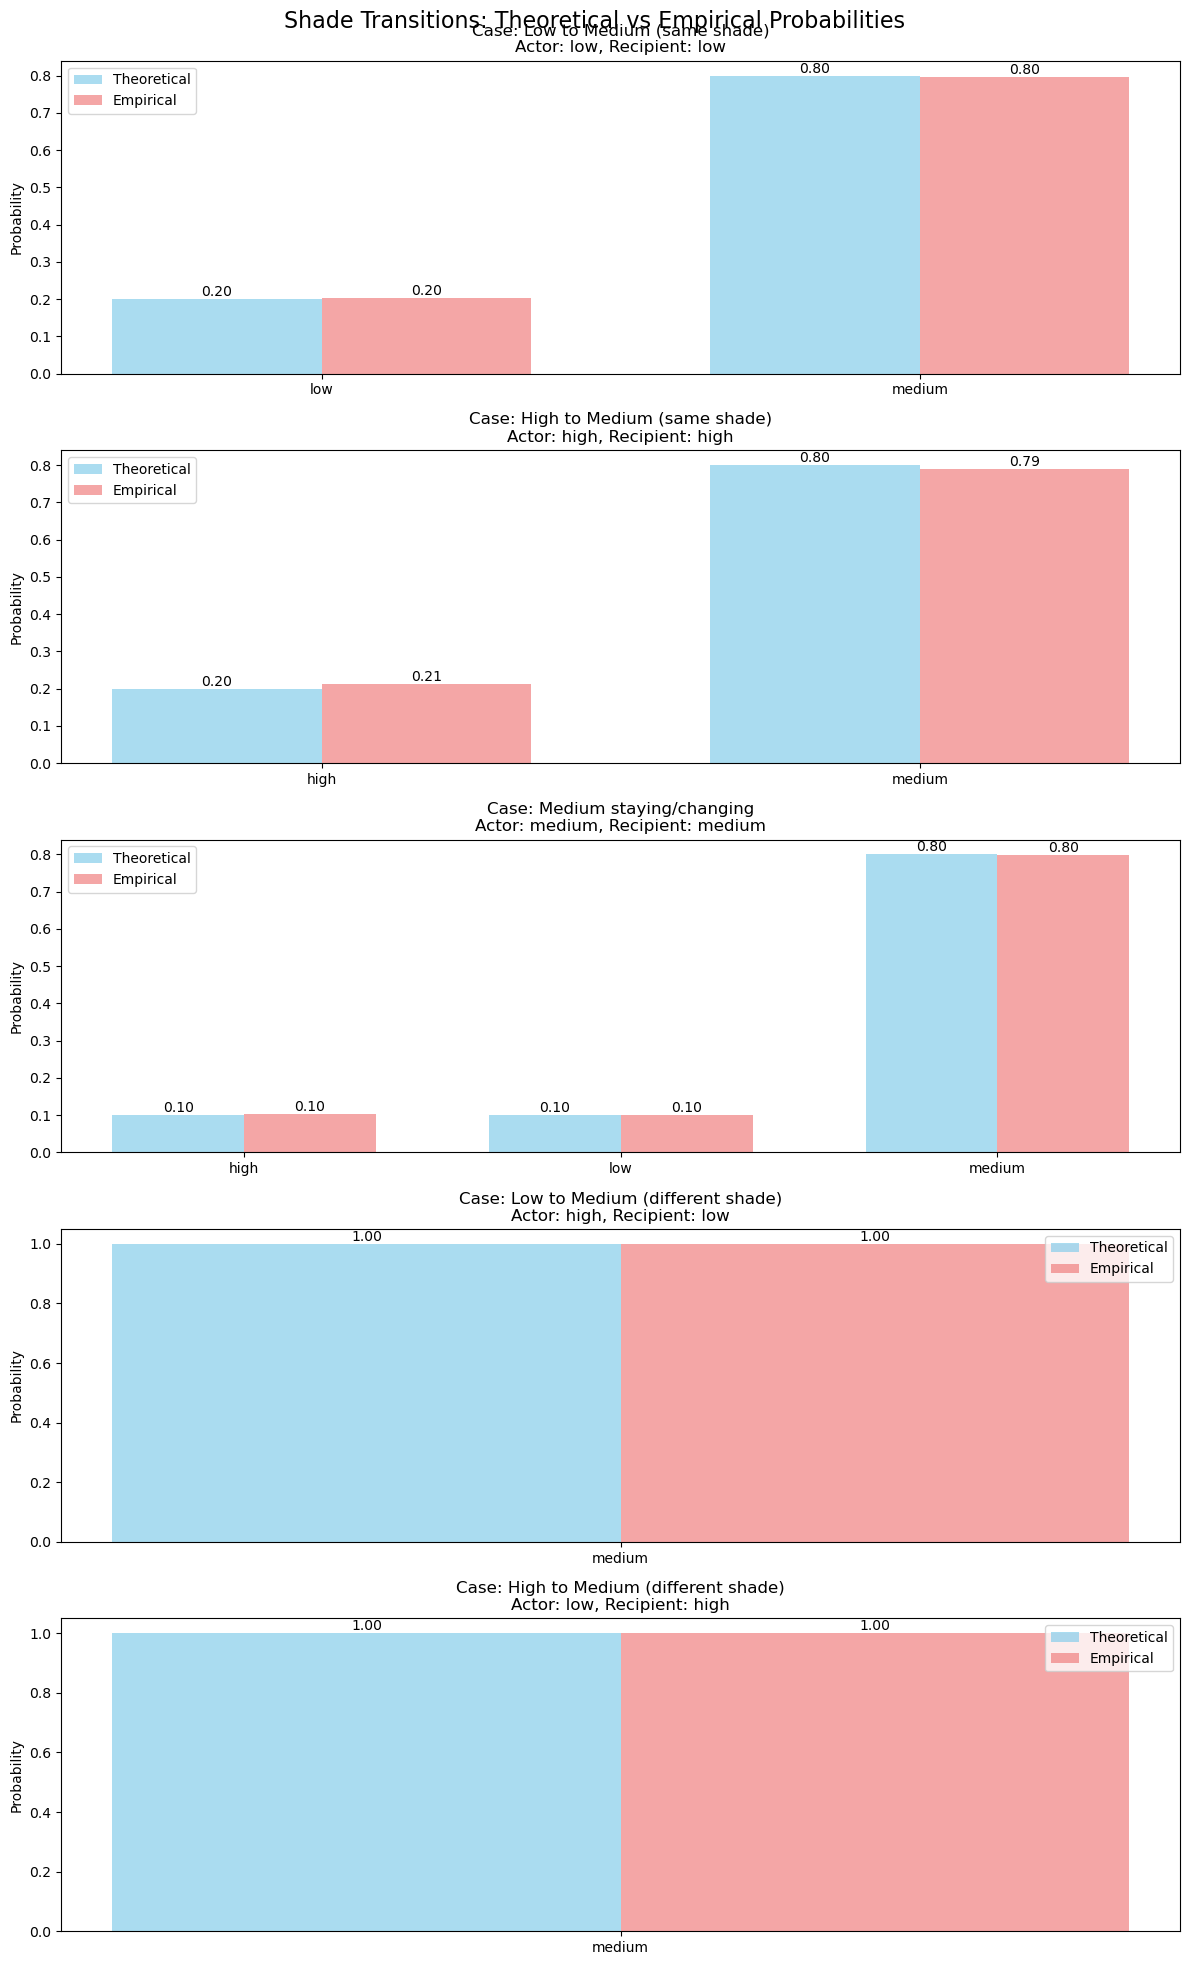

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def test_shade_transitions(shape_world, n_samples=10000):
    """Test different types of shade transitions and visualize results."""
    
    # Define test cases
    test_cases = [
        {
            'name': 'Low to Medium (same shade)',
            'actor_shade': 'low',
            'recipient_shade': 'low'
        },
        {
            'name': 'High to Medium (same shade)',
            'actor_shade': 'high',
            'recipient_shade': 'high'
        },
        {
            'name': 'Medium staying/changing',
            'actor_shade': 'medium',
            'recipient_shade': 'medium'
        },
        {
            'name': 'Low to Medium (different shade)',
            'actor_shade': 'high',
            'recipient_shade': 'low'
        },
        {
            'name': 'High to Medium (different shade)',
            'actor_shade': 'low',
            'recipient_shade': 'high'
        }
    ]

    # Create figure
    fig, axes = plt.subplots(len(test_cases), 1, figsize=(12, 4*len(test_cases)))
    fig.suptitle('Shade Transitions: Theoretical vs Empirical Probabilities', fontsize=16)

    # Test each case
    for idx, test_case in enumerate(test_cases):
        # Create initial state
        initial_state = State(
            shape1=Shape(sides='circle', shade=test_case['actor_shade'], texture='plain'),
            shape2=Shape(sides='circle', shade=test_case['recipient_shade'], texture='plain'),
            shape3=Shape(sides='circle', shade='medium', texture='plain')
        )
        shade_action = Action(feature='shade', actor=1, recipient=2)

        # Get theoretical probabilities
        possible_states = shape_world.get_possible_next_states(initial_state, shade_action)
        theoretical_probs = {
            ns.shape2.shade: shape_world.transition_probability(initial_state, shade_action, ns)
            for ns in possible_states
        }

        # Generate samples
        samples = [
            shape_world.next_state_sample(initial_state, shade_action).shape2.shade 
            for _ in range(n_samples)
        ]
        empirical_counts = Counter(samples)
        empirical_probs = {shade: count/n_samples for shade, count in empirical_counts.items()}

        # Prepare data for plotting
        shades = sorted(set(theoretical_probs.keys()) | set(empirical_probs.keys()))
        theoretical = [theoretical_probs.get(shade, 0) for shade in shades]
        empirical = [empirical_probs.get(shade, 0) for shade in shades]

        # Create bar plot
        ax = axes[idx]
        x = range(len(shades))
        width = 0.35

        ax.bar([i - width/2 for i in x], theoretical, width, 
               label='Theoretical', color='skyblue', alpha=0.7)
        ax.bar([i + width/2 for i in x], empirical, width, 
               label='Empirical', color='lightcoral', alpha=0.7)

        # Customize plot
        ax.set_ylabel('Probability')
        ax.set_title(f'Case: {test_case["name"]}\n'
                    f'Actor: {test_case["actor_shade"]}, '
                    f'Recipient: {test_case["recipient_shade"]}')
        ax.set_xticks(x)
        ax.set_xticklabels(shades)
        ax.legend()

        # Add probability labels
        for i, (t, e) in enumerate(zip(theoretical, empirical)):
            if t > 0:
                ax.text(i - width/2, t, f'{t:.2f}', ha='center', va='bottom')
            if e > 0:
                ax.text(i + width/2, e, f'{e:.2f}', ha='center', va='bottom')

        # Print statistics
        print(f"\nCase: {test_case['name']}")
        print(f"Actor shade: {test_case['actor_shade']}")
        print(f"Recipient shade: {test_case['recipient_shade']}")
        print("\nTheoretical probabilities:")
        for shade, prob in theoretical_probs.items():
            print(f"  {shade}: {prob:.3f}")
        print("\nEmpirical probabilities:")
        for shade, prob in empirical_probs.items():
            print(f"  {shade}: {prob:.3f}")
        print("\nAbsolute differences:")
        for shade in shades:
            diff = abs(theoretical_probs.get(shade, 0) - empirical_probs.get(shade, 0))
            print(f"  {shade}: {diff:.3f}")

    plt.tight_layout()
    plt.show()

# Run the tests
print("Running shade transition tests...")
test_shade_transitions(shape_world)